### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import networkx as nx
from typing import Literal

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)


KeyboardInterrupt: 

### Testing PyG

In [2]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


### Parameters

In [15]:
batch_size = 64                 # 64 used for Graphs in PGE (PGExplainer/codes/forgraph/config.py)      1 takes forever in current model

learning_rate_gnn = 0.001        #0.001 on ADAM
epochs_gnn = 1000
early_stopping = 500

loss = nn.CrossEntropyLoss()           # cross entropy loss?!

datasetName: Literal['BA2Motif','MUTAG'] = 'MUTAG'

# lr scheduler? => not used in orig
# softmax after linear layer?       -> Not really needed since kinda used in CEL; PyTorch best practice to just use Linear in final layer

# DONE: Xavier uniform distr used for init in PGExplainer
# DONE: dropout     NOT USED IN OG
# DONE: early stopping with validation set

In [ ]:
def weights_init(module):
    # TODO: GraphConv has no attribute weight!!
    #if isinstance(module, gnn.GraphConv):
    #    nn.init.xavier_normal_(module.weight.data)
    #    if module.bias is not None:
     
    # This only initializes weight for lin layer, not GraphConv
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        #if module.bias is not None:            # Xavier not usable for bias?


#### Load and visualize dataset

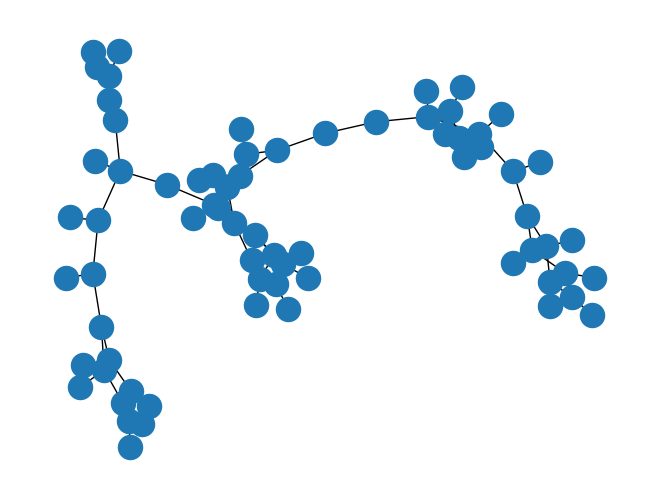

In [23]:
train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

# TODO: Color different classes? Problem: BA2Motif Graph datasets have no node labels?!
g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g)

train_loader = DataLoader(train_dataset, batch_size, True)
val_loader = DataLoader(val_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size)

## Training Loop GraphGNN

In [ ]:
gnn = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)       # temp.y.shape[0] is wrong!!! TODO: how do I get #labels from loader?? take from loader.dataset? Store with dataset

# Applies xavier to nn.Linear. GraphConv weight init done in network
gnn.apply(weights_init)

gnn_optimizer = torch.optim.Adam(params = gnn.parameters(), lr = learning_rate_gnn)         # TODO: understand params

print(f"Training on {len(train_loader.dataset)} graphs with batch size {batch_size}")

early_stop_counter = 0
min_val_loss = 1000.0
best_val_acc = 0
best_epoch = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(0, epochs_gnn) :
    print(f'\n------------------ EPOCH {epoch + 1} -------------------')

    gnn.train()

    train_acc_sum = 0
    num_batches = 0.0
    train_loss = 0.0

    for batch_index, data in enumerate(train_loader):
        batch_size_ratio = len(data)/batch_size
        num_batches += batch_size_ratio
        
        gnn_optimizer.zero_grad()       # Reset parameters

        # get model embeddings (node representations)?
        out = gnn.forward(data.x, data.edge_index, data.batch)

        # calc cross entropy(???)loss between real label and predicted label
        # needs to be calculated across batch
        currLoss = loss(out, data.y)

        # loss backward
        currLoss.backward()
        
        torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=2)    # clip gradient above 2(for ba2motfis according to reimplementation) to stop "overlearning"?

        # optimizer step
        gnn_optimizer.step()

        # predicted labels
        preds = out.argmax(dim=1)
        train_acc_sum += torch.sum(preds == data.y)                         # DONE: works with batches?
        
        train_loss += batch_size_ratio * currLoss.item()                    # use currLoss.item() instead of currLoss for numeric value

    final_train_acc = train_acc_sum/(num_batches*batch_size)                # num_batches*batch_size = len(train_loader.dataset) = #graphs

    gnn.eval()

    # avg loss
    print(f"average training loss: {train_loss/num_batches}, training acc: {final_train_acc}")

    train_losses.append(train_loss/num_batches)
    train_accuracies.append(final_train_acc)

    val_acc, valLoss = evaluation.evaluateGraphGNN(gnn, val_loader)
    
    print(f"validation loss: {valLoss}, validation acc: {val_acc}")

    val_losses.append(valLoss)
    val_accuracies.append(val_acc)

    if(val_acc > best_val_acc):
        best_val_acc = val_acc
        best_epoch = epoch
    if(valLoss < min_val_loss):
        min_val_loss = valLoss
        early_stop_counter = 0
    elif(valLoss > min_val_loss):
        early_stop_counter += 1
        if early_stop_counter >= early_stopping:
            print("Stopping training due to early stopping threshold")
            break
              
print(f"highest validation accuracy: {best_val_acc} in epoch {best_epoch}") 

Training on 3470 graphs with batch size 64

------------------ EPOCH 1 -------------------
average training loss: 0.6821305266374813, training acc: 0.5423631072044373
validation loss: 0.6578071199803858, validation acc: 0.5714285969734192

------------------ EPOCH 2 -------------------
average training loss: 0.646632255738338, training acc: 0.6086455583572388
validation loss: 0.6276274372905081, validation acc: 0.6658986210823059

------------------ EPOCH 3 -------------------
average training loss: 0.6191219399401365, training acc: 0.6648414731025696
validation loss: 0.6054462911346541, validation acc: 0.6889401078224182

------------------ EPOCH 4 -------------------
average training loss: 0.5988462392809755, training acc: 0.6974063515663147
validation loss: 0.5948159991321476, validation acc: 0.7073732614517212

------------------ EPOCH 5 -------------------
average training loss: 0.5830896740344484, training acc: 0.7048991322517395
validation loss: 0.5958946836159525, validation ac

### GCNConv instead of GraphConv
average training loss: 0.3523677970215635, training acc: 0.8458213210105896
validation loss: 0.47687009828431265, validation acc: 0.7921478152275085, test loss: 0.5093637616952993, test acc: 0.7695852518081665
highest validation accuracy: 0.8152424693107605 in epoch 452

### Save Model

In [30]:
torch.save(gnn.state_dict(), f"models/MUTAG SAGEConv 82 test 83 val")

### Load model

In [ ]:
#gnn = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)
#gnn.load_state_dict(torch.load("models/MUTAG 86 highest val", weights_only=True))

RuntimeError: Error(s) in loading state_dict for GraphGNN:
	Missing key(s) in state_dict: "hidden1.lin_l.weight", "hidden1.lin_l.bias", "hidden1.lin_r.weight", "hidden2.lin_l.weight", "hidden2.lin_l.bias", "hidden2.lin_r.weight", "hidden3.lin_l.weight", "hidden3.lin_l.bias", "hidden3.lin_r.weight". 
	Unexpected key(s) in state_dict: "hidden1.lin_rel.weight", "hidden1.lin_rel.bias", "hidden1.lin_root.weight", "hidden2.lin_rel.weight", "hidden2.lin_rel.bias", "hidden2.lin_root.weight", "hidden3.lin_rel.weight", "hidden3.lin_rel.bias", "hidden3.lin_root.weight". 

### Calculate test accuracy and loss

In [ ]:
gnn.eval()

test_acc, testLoss = evaluation.evaluateGraphGNN(gnn, test_loader)
print(f"test loss: {testLoss}, test acc: {test_acc}")

test loss: 0.4248317113924797, test acc: 0.8244803547859192


### Plot Losses

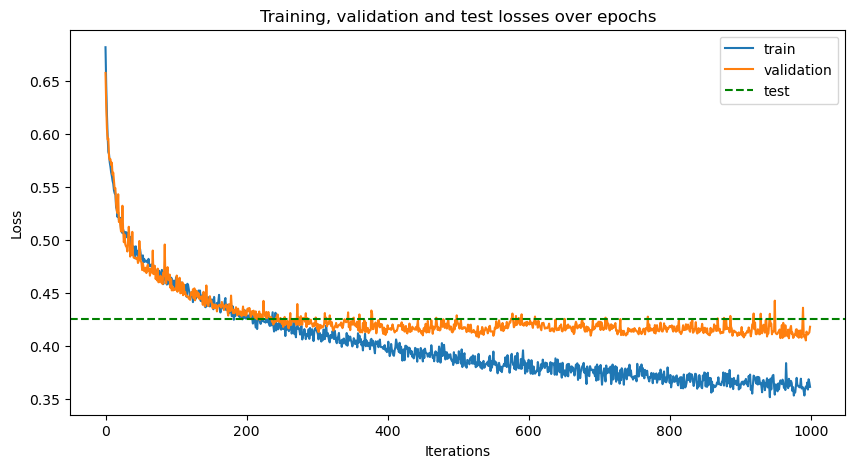

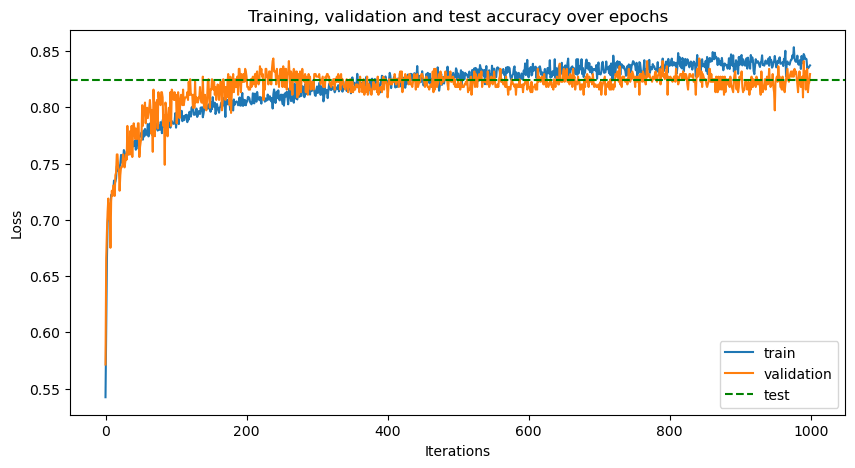

In [31]:
#   Losses
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test losses over epochs")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.axhline(y=testLoss, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#   Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test accuracy over epochs")
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.axhline(y=test_acc, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Testing

In [152]:
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
from torch_geometric.datasets.motif_generator import CycleMotif
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader

dataset1 = ExplainerDataset(
            graph_generator=BAGraph(20, 1),
            motif_generator=HouseMotif(),
            num_motifs=1,
            num_graphs=400,
            transform=T.Constant()      # appends value 1 node feature for every node
        )

dataset2 = ExplainerDataset(
            graph_generator=BAGraph(20, 1),
            motif_generator=CycleMotif(5),
            num_motifs=1,
            num_graphs=400,
            transform=T.Constant()
        )

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

print(dataset[0])

print(dataset)
dataset[0].y = torch.tensor([0])

print(dataset[0].y)

train_loader = DataLoader(dataset1, batch_size = 1, shuffle = True)

print(next(iter(train_loader)).y)

Explanation(edge_index=[2, 50], y=[25], edge_mask=[50], node_mask=[25], x=[25, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
        3])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
        3])


In [40]:
generator1 = torch.Generator().manual_seed(42)
generator2 = torch.Generator().manual_seed(42)
set1, set2 = torch.utils.data.random_split(range(10), [3, 7])
set3, set4, set5 = torch.utils.data.random_split(range(30), [0.3, 0.3, 0.4])

print("Set 1:")
print(set1[0])
print(set1[1])
print(set1[2])
print("Set 2:")
print(set2[0])
print(set2[1])
print(set2[2])
print(set2[3])
print(set2[4])
print(set2[5])
print(set2[6])

Set 1:
9
3
5
Set 2:
2
6
4
8
7
0
1
